In [1]:
%load_ext autoreload
%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import clipboard
sys.path.append('/Users/orenm/BlenderShaderProject/project_files/')

In [2]:
%autoreload 2
from Logic.network_manager import NetworkManager
from Logic.meta_network import MetaNetworkManager
from Logic.generation_db_and_manager import *
from Logic.variations_creator import *
from Logic.bpy_connector import generate_image
from Logic.utils import compare_dicts, deep_unfreeze, show_image_grid

In [3]:
path = '/Users/orenm/BlenderShaderProject/data/'
images_path = os.path.join(path, 'images/')
db_path = os.path.join(path, 'DB/')

In [4]:
structural_changes = [add_random_node_on_edge, add_random_edge, remove_random_edge, remove_random_node]
to_nothing_variation
change_seed
change_numeric
change_params

<function Logic.generation_db_and_manager.change_params(nm, n_changes=3)>

In [5]:
db_manager = DBManager(db_path)

In [6]:
# db_manager = DBManager.load(db_path)

In [8]:
mega_nodes
regular_meta_nodes
completely_random_generation

n_clusters = 1
kwargs = {'max_layers': 2, 'n_additions': 2}
make_clusters(db_manager, n_clusters, completely_random_generation, kwargs)

Info: Deleted 3 data-block(s)


In [30]:
variation_types = [change_seed]
variation_types = [change_seed, change_numeric, change_params]
n_variations = 50

# get relevant nodes - non empty
legit_nodes = db_manager.get_nodes_with_label(IS_CLUSTER_BASE)
# legit_nodes = db_manager.get_nodes_without_label(IS_EMPTY_NETWORK)

In [31]:
for i in range(n_variations):
    selected_node = np.random.choice(legit_nodes)
    selected_variation_func = np.random.choice(variation_types)
    
    network_node = db_manager.network_managers[selected_node]
    two_way_variations = selected_variation_func(network_node)
    
    if two_way_variations is None:
        print(f'Attempted to create variation: {selected_variation_func.__name__} but no variation was created')
        continue
    
    new_nodes = db_manager.add_sequence(selected_node, two_way_variations)
    
    # connect to other nodes that are connected to the same node
    non_structural_variation_types = [VariationType.SEED, VariationType.NUMERIC, VariationType.CAT_AND_NUMERIC]
    if len(two_way_variations.steps_backward) == 1 and two_way_variations.steps_backward[0].variation_type in non_structural_variation_types:
        assert len(new_nodes) == 1, 'If steps backwards is 1 there should only have been one new node'
        db_manager.connect_new_node_to_existing_connections(new_nodes[0], selected_node, two_way_variations)

In [9]:
len(db_manager.network)

14

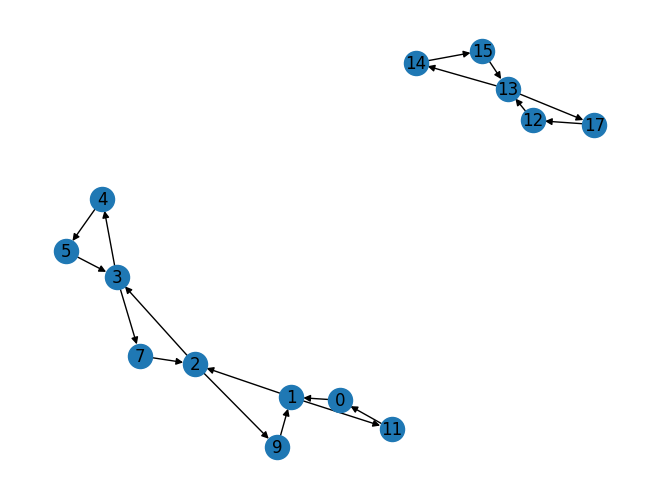

In [10]:
db_manager.draw_network()

In [11]:
db_manager.get_nodes_with_label(IS_EMPTY_NETWORK)

['4', '14']

In [50]:
# don't override!!!!!!!!!!!!!!
db_manager.generate_images(images_path, override_images=True)

working on image 33/34
Info: Deleted 3 data-block(s)
Generated 34 images, including 0 empty images, in 46.0 seconds


In [50]:
db_manager.save()

# Images investigation

In [47]:
relevant_nodes = db_manager.get_nodes_without_label(IS_CLUSTER_BASE)
# relevant_nodes = db_manager.get_nodes_with_label(IS_CLUSTER_BASE)
len(relevant_nodes)

32

In [51]:
nodes_to_show = np.random.choice(relevant_nodes, min(16, len(relevant_nodes)), replace=False)
# nodes_data = [(node_id, [x for x in db_manager.network.nodes[node_id]['labels'] if 'generation' in x][0]) for node_id in nodes_to_show]

nodes_data = [(node_id, '') for node_id in nodes_to_show]

img_paths = [(os.path.join(images_path, f"{node_id}.png"), f'{text}, {node_id}') for node_id, text in nodes_data]

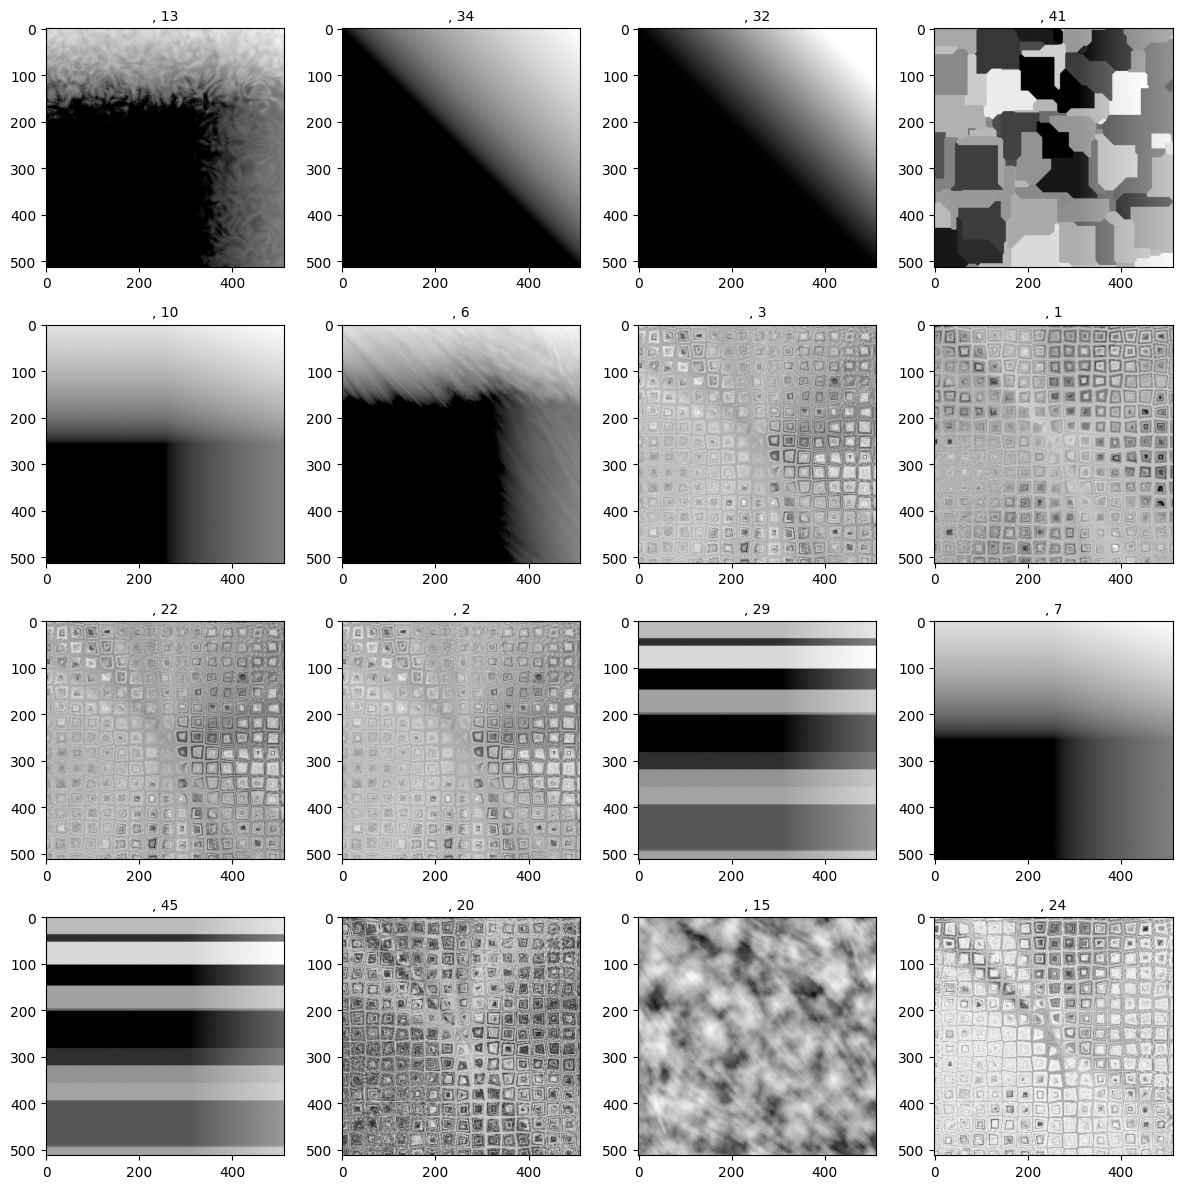

In [52]:
show_image_grid(img_paths)

In [21]:
# by a single node - show variations on it

In [20]:
# SEED, NUMERIC, CAT_AND_NUMERIC
edge_show = 'CAT_AND_NUMERIC'

In [21]:
cluster_bases = db_manager.get_nodes_with_label(IS_CLUSTER_BASE)
cluster_bases = db_manager.get_nodes_with_edge_type(edge_show)

In [30]:
base_node = np.random.choice(cluster_bases)
connected_nodes = db_manager.network.edges(base_node, data=True)

connected_nodes = [x for x in connected_nodes if x[2]['variation_type'] == edge_show]

nodes_data = [(base_node, 'base_node')]
nodes_data.extend([(node_id, d['variation_type']) for _, node_id, d in connected_nodes])
img_paths = [(os.path.join(images_path, f"{node_id}.png"), f'{text}, {node_id}') for node_id, text in nodes_data]

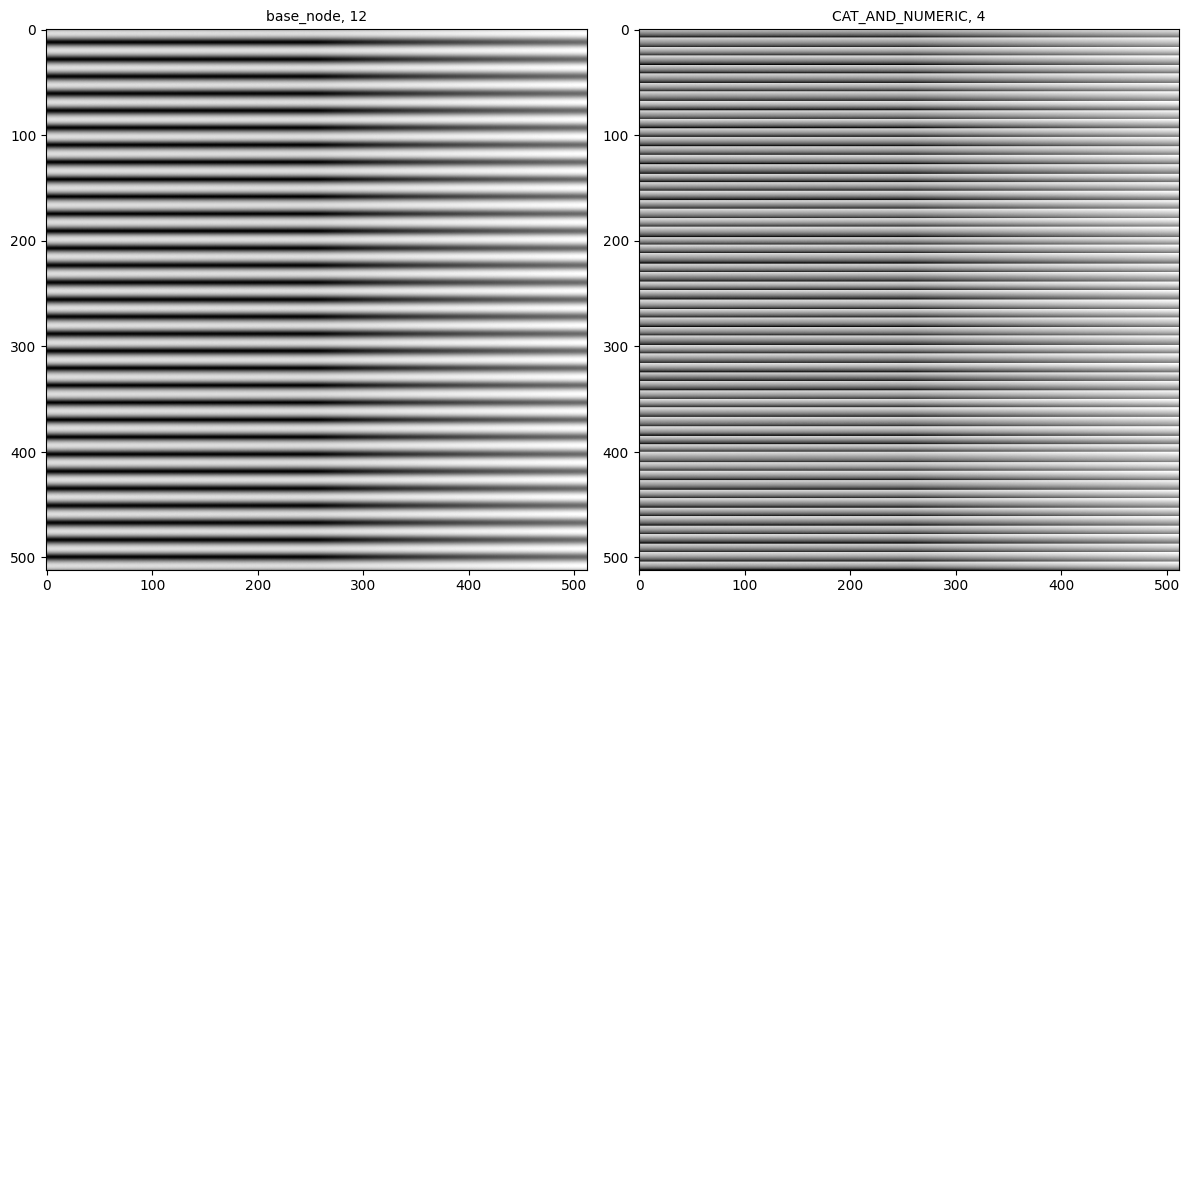

In [31]:
show_image_grid(img_paths)

In [99]:
nm1 = db_manager.network_managers['537']
nm2 = db_manager.network_managers['538']

In [100]:
NetworkManager.find_nodes_differences(nm1, nm2)

defaultdict(dict,
            {'MixVector_1': {'A': ([0, 0, 0], [0.7, 0.3, 0.6]),
              'blend_type': ('ADD', 'BURN')}})

In [71]:
code = nm2.generate_code(with_initialization_code=True)
clipboard.copy(code)

# tests that db manager works

In [32]:
for i in range(20):
    clear_output()
    some_node = np.random.choice(list(db_manager.network_managers))
    
    current_node = some_node
    
    orig_copy = db_manager.network_managers[some_node].copy()
    for _ in range(20):
        print(current_node)
        # Get incoming edges for the current node
        outgoing_edges = list(db_manager.network.out_edges(current_node, data=True))
        # Pick a random incoming edge
        edge = outgoing_edges[np.random.randint(len(outgoing_edges))]
        # Move to the new node
        current_node = edge[1]  # The source of the edge becomes the new node
        nm_after =  db_manager.network_managers[current_node]
        variation = VariationDescriptor(VariationType[edge[2]['variation_type']], edge[2]['step'])
        apply_variation(orig_copy, variation)
        assert orig_copy == nm_after

12
4
5
6
7
8
6
7
8
6
7
8
6
7
8
6
10
5
12
4


In [30]:
db_manager.save()
new_db = DBManager.load(db_path)
assert db_manager.network.nodes(data=True) == new_db.network.nodes(data=True)
a = list(db_manager.network.edges(data=True))
b = list(new_db.network.edges(data=True))
assert compare_dicts(a, b)